# Projected Gradient Descent


This notebook is based on a demo I often show at conferences where I implement Projected Gradient Descent to prevent a theoretical Skynet machine learning model from recognising the gun Sarah Connor is holding. We're going to implement it as an untargeted attack (there is no specific classification in mind) and a targeted attack (we are going to force it predict a specific class).

# Set up

First we import the required packages.

In [ ]:
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from PIL import Image
import IPython.display as display

We now import our victim AI model - an open source image classification model called MobileNetV2. (Sorry we're not actually hacking the real Skynet).
We download it from the tensorflow.keras package, and we also need to download the ImageNet labels (decode_predictions).

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

14536120/14536120 [==============================] - 0s 0us/step


We define some helper functions to do things like process and import images. Note for me: different image here?


In [ ]:
# Function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  if image.shape[0] == 1:
        image = image[0]
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

def import_image():
  !wget https://raw.githubusercontent.com/harrietf/milevademos/master/gun.jpeg
  # Load the image
  gitimage = Image.open('gun.jpeg')
  gitimage = np.array(gitimage)
  gitimage = preprocess(gitimage)
  image = gitimage
  return image

def display_images(image):
  plt.figure()
  plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
  _, image_class, class_confidence = get_imagenet_label(image_probs)
  plt.show()

Now we want to show the image we are importing - Sarah Connor's gun.

In [ ]:
mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

In [ ]:
image = import_image()
image_probs = pretrained_model.predict(image)

--2024-07-18 09:18:43--  https://raw.githubusercontent.com/harrietf/milevademos/master/gun.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166684 (163K) [image/jpeg]
Saving to: ‘gun.jpeg’

gun.jpeg            100%[===================>] 162.78K  --.-KB/s    in 0.02s   

2024-07-18 09:18:44 (6.79 MB/s) - ‘gun.jpeg’ saved [166684/166684]

1/1 [==============================] - 1s 1s/step


Plotting the image and showing prediction

35363/35363 [==============================] - 0s 0us/step


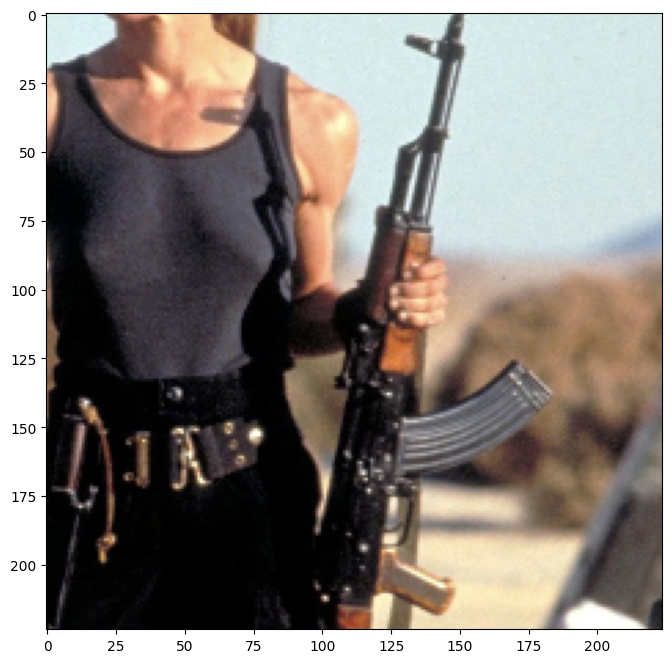

In [ ]:
display_images(image)

And we show what MobileNetV2 predicts this image to be

In [ ]:
decode_predictions(pretrained_model.predict(image))

1/1 [==============================] - 0s 59ms/step


[[('n02749479', 'assault_rifle', 0.49408048),
  ('n04090263', 'rifle', 0.3577457),
  ('n02804610', 'bassoon', 0.0214487),
  ('n02879718', 'bow', 0.010068663),
  ('n04086273', 'revolver', 0.008851121)]]

Success! It correctly predicts it's an assault rifle (not with a high confidence mind you)

# Implementing the untargeted attack

We are now implementing the PGD attack, without a specific target for the model to predict (we just want to dusrupt it)

In [ ]:
#Indices of labels
real_label_index = 413 #rifle

#Real label
real_label = tf.one_hot(real_label_index, image_probs.shape[-1])
real_label = tf.reshape(real_label, (1, image_probs.shape[-1]))

loss_object = tf.keras.losses.CategoricalCrossentropy()
input_image = image

In [ ]:
LR = 5e-3
EPS = 2 / 255.0 #Clipping the delta values so it's not too obvious
iterations = 20

#Creating empty tensor to populate based on gradient of target and original
delta = tf.Variable(tf.zeros_like(image), trainable=True)
baseImage = tf.constant(image, dtype=tf.float32)
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

In [ ]:
#defining the function to clip values
def clip_eps(tensor, eps):
	# clip the values of the tensor to a given range and return it
	return tf.clip_by_value(tensor, clip_value_min=-eps,
		clip_value_max=eps)

In [ ]:
#performing the optimisation, generating perturbation vector
for iteration in range(0, iterations):
  with tf.GradientTape() as tape:
    tape.watch(delta)
    adversary = baseImage + delta
    prediction = pretrained_model(adversary)

    real_loss = loss_object(real_label, prediction)
    #target_loss = loss_object(target_label, prediction)
    total_loss = -real_loss

  gradient = tape.gradient(total_loss, delta)
  signed_grad = tf.sign(gradient)

  optimizer.apply_gradients([(gradient, delta)])
  delta.assign_add(clip_eps(delta, eps=EPS))

Now let's have a look at our 'adversarial example'

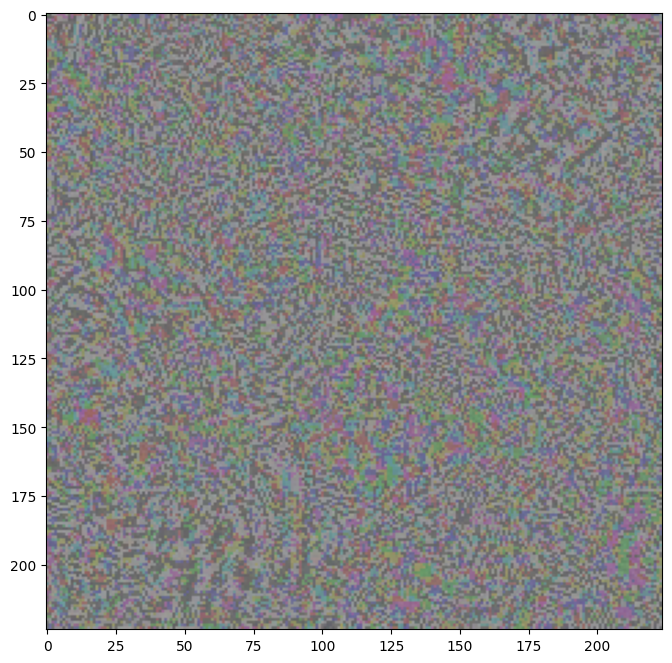

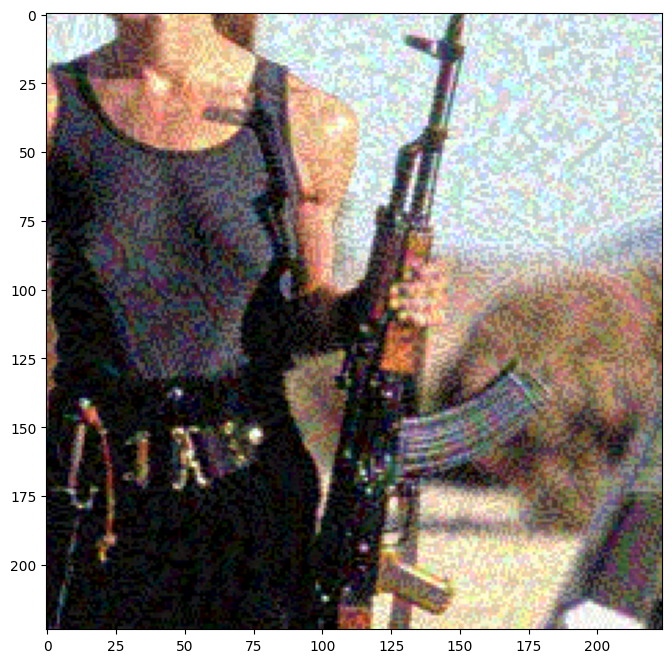

In [ ]:
new_img = image + (delta)
display_images(delta)
display_images(new_img)
#decode_predictions(pretrained_model.predict(new_img))

And let's see what the model predicts now.

In [ ]:
decode_predictions(pretrained_model.predict(new_img))

1/1 [==============================] - 0s 76ms/step


[[('n02804610', 'bassoon', 0.9999982),
  ('n03838899', 'oboe', 1.6470004e-06),
  ('n04141076', 'sax', 9.960295e-08),
  ('n03372029', 'flute', 1.6247988e-08),
  ('n04487394', 'trombone', 5.580837e-09)]]

Fun!

# Implementing the targeted attack

We're going to select a target label that is as different as possible to the true label to show how effective this can be.. let's go with Starfish

In [ ]:
#Indices of labels
real_label_index = 413 #Assault rifle
target_label_index = 327 #Starfish

#Real label - air carrier
real_label = tf.one_hot(real_label_index, image_probs.shape[-1])
real_label = tf.reshape(real_label, (1, image_probs.shape[-1]))

#Target label
target_label = tf.one_hot(target_label_index, image_probs.shape[-1])
target_label = tf.reshape(target_label, (1, image_probs.shape[-1]))

loss_object = tf.keras.losses.CategoricalCrossentropy()
input_image = image

In [ ]:
LR = 5e-3
EPS = 2 / 255.0 #Clipping the delta values so it's not too obvious
iterations = 20

#Creating empty tensor to populate based on gradient of target and original
delta = tf.Variable(tf.zeros_like(image), trainable=True)
baseImage = tf.constant(image, dtype=tf.float32)
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

In [ ]:
#defining the function to clip values
def clip_eps(tensor, eps):
	# clip the values of the tensor to a given range and return it
	return tf.clip_by_value(tensor, clip_value_min=-eps,
		clip_value_max=eps)

We now perform the optimisation again, but we add an extra constraint - the target label

In [ ]:
#performing the optimisation, generating perturbation vector
for iteration in range(0, iterations):
  with tf.GradientTape() as tape:
    tape.watch(delta)
    adversary = baseImage + delta
    prediction = pretrained_model(adversary)

    real_loss = loss_object(real_label, prediction)
    target_loss = loss_object(target_label, prediction)
    total_loss = target_loss - real_loss #True loss is negative because we're going in opposite direction

  gradient = tape.gradient(total_loss, delta)
  signed_grad = tf.sign(gradient)

  optimizer.apply_gradients([(gradient, delta)])
  delta.assign_add(clip_eps(delta, eps=EPS))

Let's see our adversarial example this time

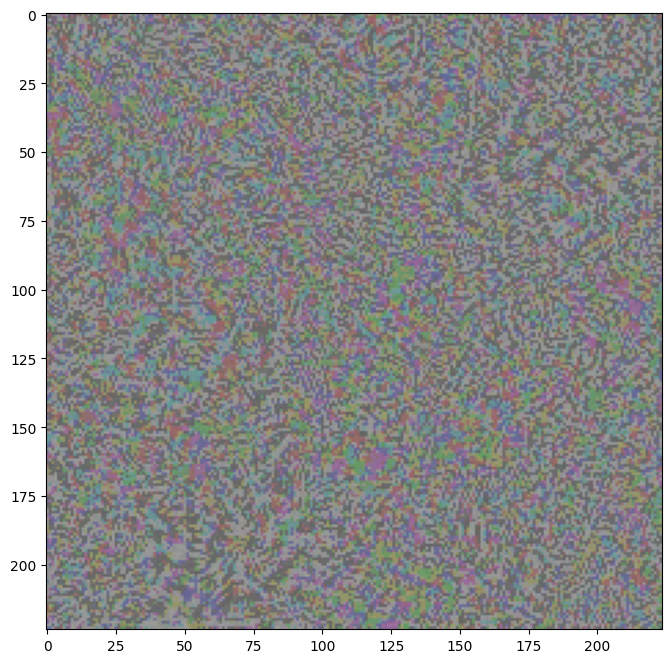

In [ ]:
display_images(delta)

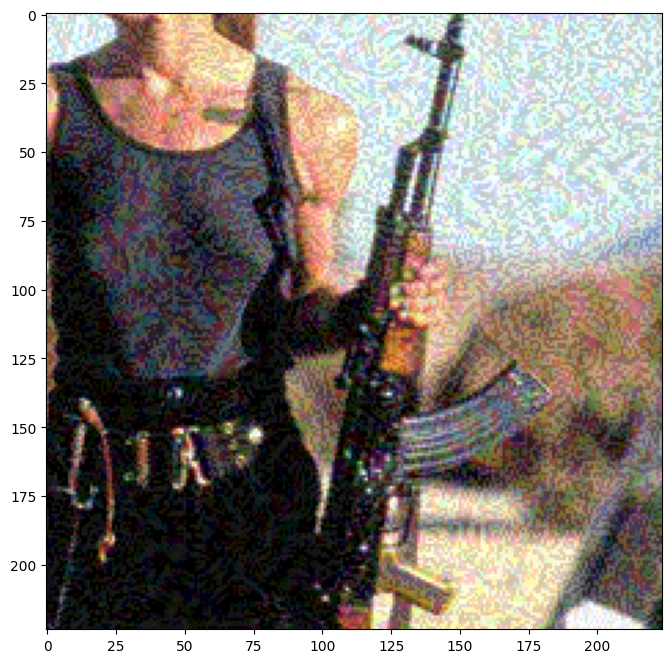

In [ ]:
new_img = image + delta
display_images(new_img)

Now let's see what our target model predicts

In [ ]:
#display_images(new_img)
decode_predictions(pretrained_model.predict(new_img))

1/1 [==============================] - 0s 51ms/step


[[('n02317335', 'starfish', 0.99999905),
  ('n02319095', 'sea_urchin', 7.7733364e-07),
  ('n01984695', 'spiny_lobster', 3.618595e-08),
  ('n01704323', 'triceratops', 2.2882256e-08),
  ('n01985128', 'crayfish', 1.9377628e-08)]]

Success! We have been able to:


*   Disrupt the model: prevent it from correctly recognising the rifle
*   Deceive the model: cause the model to predict a specific target of our choosing

